In [1]:
%matplotlib inline

# Enable Retina mode for higher-res on Macbook's with Retina Display
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [3]:
itemsDF = sqlContext.read.format("json") \
            .load("file:/root/pipeline/myapps/html/advancedspark.com/json/software.json") \
            .select("id", "title", "category", "description")

In [4]:
import pyspark.sql.functions as func

categoriesDF = itemsDF.select("category") \
                 .groupBy("category") \
                 .count() \
                 .orderBy("count", ascending=False) \
                 .filter("count > 10") \
                 .toPandas()

categoriesDF

,category,count
0,Library,15
1,Database,12
2,Data Processing,11


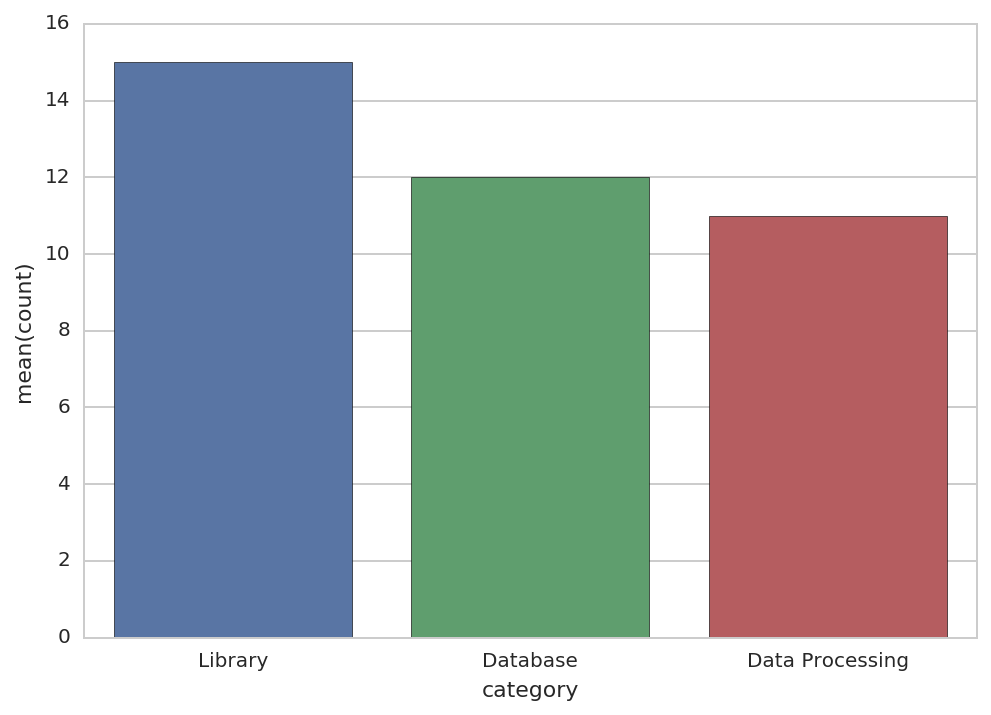

In [5]:
sns.set_style("whitegrid")
plot = sns.barplot(x="category", y="count", data=categoriesDF)

In [6]:
from pyspark.ml.feature import RegexTokenizer

tokenizer = RegexTokenizer(inputCol = "description", \
                           outputCol="words", \
                           gaps=False, \
                           pattern="\\p{L}+")
tokenizer

RegexTokenizer_4824b0ee97579ac11a71

In [7]:
from pyspark.ml.feature import StopWordsRemover

stopWordsFilter = StopWordsRemover(inputCol = "words", \
                                   outputCol = "filteredWords", \
                                   caseSensitive = False)
stopWordsFilter

StopWordsRemover_49e08ec5b8fe56255763

In [8]:
from pyspark.ml.feature import HashingTF

tf = HashingTF(inputCol = "filteredWords", \
               outputCol = "tfFeatures")
                                   
tf

HashingTF_4eb9936b910c2f5adb58

In [9]:
from pyspark.ml.feature import IDF

idf = IDF(inputCol = "tfFeatures", \
          outputCol = "idfFeatures")
                                   
idf

IDF_47eab0caf47f6c97534a

In [10]:
from pyspark.ml.feature import StringIndexer

categoryIndexer = StringIndexer(inputCol = "category", \
                                outputCol = "indexedCategory") 

categoryIndexerModel = categoryIndexer.fit(itemsDF)

categoryIndexerModel

StringIndexer_45f4a10a18894adcf517

In [11]:
from pyspark.ml.classification import RandomForestClassifier

classifier = RandomForestClassifier(featuresCol = "idfFeatures", \
                                    labelCol = "indexedCategory", \
                                    predictionCol = "prediction", \
                                    rawPredictionCol = "confidence", \
                                    probabilityCol = "probability")
classifier

RandomForestClassifier_41cc86e845efe481d6a6

In [12]:
from pyspark.ml.feature import IndexToString

categoryReverseIndexer = IndexToString(inputCol = "prediction", \
                                       outputCol = "predictedCategory", \
                                       labels = categoryIndexerModel.labels)

categoryReverseIndexer

IndexToString_45b0a3eb14e16e443300

In [13]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = [tokenizer, stopWordsFilter, tf, idf, categoryIndexer, classifier, categoryReverseIndexer])

pipeline

Pipeline_496bba6ea793a2c9ad35

In [14]:
# TODO:  Implement Cross Validation and Grid Search

In [15]:
pipelineModel = pipeline.fit(itemsDF)

In [16]:
predictionsDF = pipelineModel.transform(itemsDF)

predictionsDF.select("title", "category", "predictedCategory").toPandas()

,title,category,predictedCategory
0,Apache Cassandra,Database,Database
1,Tachyon,Distributed Cache,Library
2,Apache Ambari,Cluster Provision,Library
3,Docker,Container,Library
4,Microsft Azure,Cloud Provider,Database
5,Apache Flink,Data Processing,Library
6,Apache Spark,Data Processing,Library
7,Apache Flume,Library,Library
8,Apache Giraph,Library,Library
9,Apache HDFS,File System,Library


In [19]:
# Save & load the Random Forest model
!rm -rf /tmp/spark/2.0.0/rf

pipelineModelPersistPath = "/tmp/spark/2.0.0/rf"

pipelineModel.save(pipelineModelPersistPath)

In [20]:
from pyspark.ml import PipelineModel

restoredPipelineModel = PipelineModel.load(pipelineModelPersistPath)

In [21]:
featureImportances = restoredPipelineModel.stages[5].featureImportances

featureImportances

SparseVector(262144, {14879: 0.0361, 21247: 0.0148, 26866: 0.016, 28190: 0.0115, 41989: 0.0161, 48935: 0.0812, 53718: 0.0338, 54750: 0.0284, 57388: 0.0495, 62736: 0.0833, 64841: 0.0254, 72667: 0.037, 76764: 0.0833, 83995: 0.0248, 85799: 0.011, 92854: 0.0191, 95547: 0.018, 104821: 0.0461, 139229: 0.0463, 148562: 0.0227, 156693: 0.0202, 164785: 0.0085, 206496: 0.0289, 219731: 0.0133, 226292: 0.0833, 227860: 0.0431, 239924: 0.0545, 242046: 0.0261, 252594: 0.0176})

In [22]:
restoredPipelineModel.stages[5].treeWeights

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [23]:
restoredPredictionsDF = restoredPipelineModel.transform(itemsDF)

restoredPredictionsDF.select("category", "prediction", "probability") \
  .toPandas()

,category,prediction,probability
0,Database,1.0,"[0.14219656567, 0.251893973845, 0.129918564992..."
1,Distributed Cache,0.0,"[0.159849660798, 0.14040280374, 0.149576735468..."
2,Cluster Provision,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
3,Container,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
4,Cloud Provider,1.0,"[0.158599156562, 0.178679326532, 0.14811445229..."
5,Data Processing,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
6,Data Processing,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
7,Library,0.0,"[0.206260863213, 0.142993781436, 0.14992890719..."
8,Library,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
9,File System,0.0,"[0.168058616022, 0.148611758964, 0.15554688472..."
